## Importing data

### Importing packages

In [64]:
import glob
import pandas as pd
import matplotlib.pyplot as plt

### Importing dataset 1: DayAheadPrices

In [65]:
data = []

DATA_PATH = './data/DayAheadPrices_12.1.D'

files = glob.glob(f'{DATA_PATH}/*')

for file in files:
    fn = pd.read_csv(file, sep ='\t', parse_dates=['DateTime'], index_col='DateTime')
    data.append(fn)

df = pd.concat(data).sort_index()
df = df[['ResolutionCode','MapCode','Price']]
df = df.query('MapCode == "NO2" or MapCode == "DE_LU" and ResolutionCode == "PT60M"')
df

,ResolutionCode,MapCode,Price
DateTime,,,
2019-01-01 00:00:00,PT60M,NO2,49.25
2019-01-01 00:00:00,PT60M,DE_LU,10.07
2019-01-01 01:00:00,PT60M,DE_LU,-4.08
2019-01-01 01:00:00,PT60M,NO2,49.17
2019-01-01 02:00:00,PT60M,DE_LU,-9.91
...,...,...,...
2023-12-31 21:00:00,PT60M,NO2,61.77
2023-12-31 22:00:00,PT60M,DE_LU,2.44
2023-12-31 22:00:00,PT60M,NO2,59.31


### Importing dataset 2: PhysicalFlows

In [66]:
data = []

DATA_PATH = './data/PhysicalFlows_12.1.G'

files = glob.glob(f'{DATA_PATH}/*')

for file in files:
    fn = pd.read_csv(file, sep ='\t', parse_dates=['DateTime'], index_col='DateTime')
    data.append(fn)

df2 = pd.concat(data).sort_index()
df2 = df2.query('(InMapCode == "NO2" and OutMapCode == "DE_LU") or (InMapCode == "DE_LU" and OutMapCode == "NO2")')
df2

,InMapCode,OutMapCode,FlowValue
DateTime,,,
2020-09-01 22:00:00,DE_LU,NO2,0.0000
2020-09-01 22:00:00,NO2,DE_LU,0.0000
2020-09-01 23:00:00,DE_LU,NO2,0.0000
2020-09-01 23:00:00,NO2,DE_LU,0.0000
2020-09-02 00:00:00,DE_LU,NO2,0.0000
...,...,...,...
2023-12-31 21:00:00,DE_LU,NO2,0.0000
2023-12-31 22:00:00,NO2,DE_LU,1350.5975
2023-12-31 22:00:00,DE_LU,NO2,0.0000


## Tasks

### Task 1

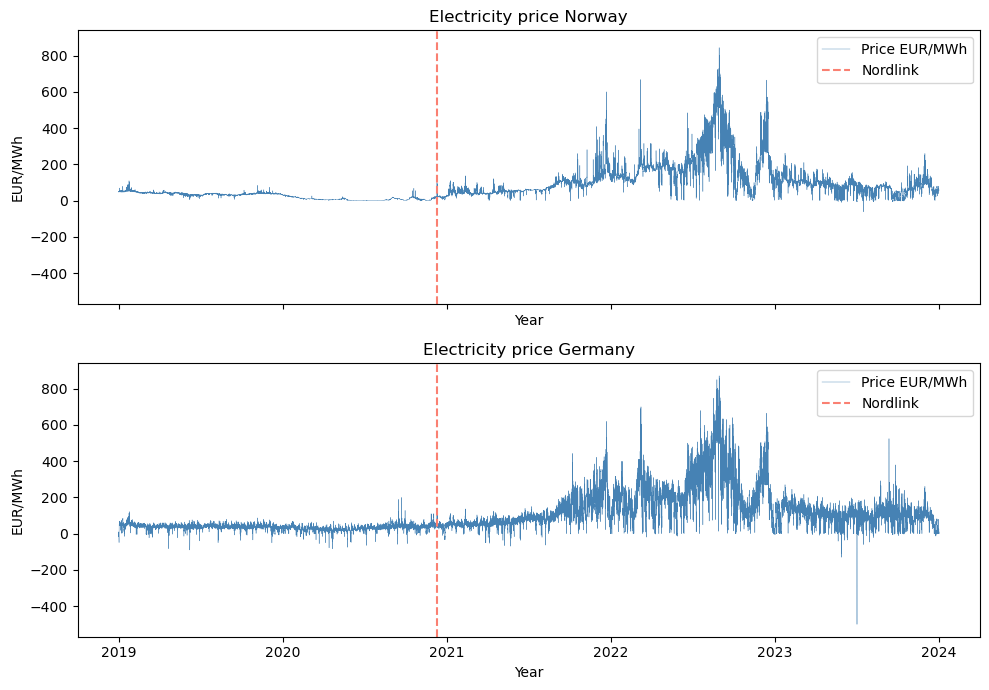

In [67]:
fig1, axes = plt.subplots(2,1, sharex=True, sharey=True, figsize=(10,7))                    # Creates subplots 

Country = ['Norway', 'Germany']                                                             # List of the two countries

xvalues = df.index.drop_duplicates()                                                        # Gets the x-values for the plots, removes duplicates
yvalues0 = df[df['MapCode'] == 'NO2']['Price']                                              # Gets the y-values for Norway
yvalues1 = df[df['MapCode'] == 'DE_LU']['Price']                                            # Gets the y-values for Germany

yvalues = [yvalues0, yvalues1]                                                              # Puts the yvalues in a list together

for i in range(2):                                                                          # For loop creating the two subplots
    axes[i].plot(xvalues, yvalues[i], lw=0.3, label='Price EUR/MWh', c='steelblue')         # Plots the electricity graph
    axes[i].axvline(pd.to_datetime('2020-12-09'), ls='--', c='salmon', label='Nordlink')    # Plots the vertical line for opening of Nordlink
    axes[i].set_title(f'Electricity price {Country[i]}')
    axes[i].set_xlabel('Year')
    axes[i].set_ylabel('EUR/MWh')                                   
    axes[i].legend()            

plt.tight_layout()                                                                          # Adjust the layout                                                     

### Task 2

In [68]:
df = df.loc['2019':'2023'].copy()               # Restricting the data for the period 2019-2023
df['Year'] = df.index.year                      # Creating a new index 'Year' containing only years in the restricted period

groups = df.groupby(['MapCode','Year'])         # Create a group, with the new index 'Year' and 'MapCode' (Norway or Germany)

table = groups.agg(                             # Creates a new table that calculates the required statistics
    Mean = ('Price', 'mean'),
    Median = ('Price', 'median'),
    Standard_deviation = ('Price', 'std'),
    Min = ('Price', 'min'),
    Max = ('Price', 'max'),
).round(2)
table                                           # Prints the table

Mean  Median  Standard_deviation     Min     Max
MapCode Year                                                    
DE_LU   2019   37.67   38.06               15.52  -90.01  121.46
        2020   30.47   30.99               17.50  -83.94  200.04
        2021   96.85   75.48               73.68  -69.00  620.00
        2022  235.44  208.34              142.82  -19.04  871.00
        2023   95.18   98.02               47.58 -500.00  524.27
NO2     2019   39.26   38.81                8.23    5.86  109.45
        2020    9.29    6.95                8.26   -1.73   99.92
        2021   75.11   59.34               47.22   -1.97  600.16
        2022  211.28  181.13              125.85    0.04  844.00
        2023   79.44   80.46               36.28  -61.84  261.85

### Task 3

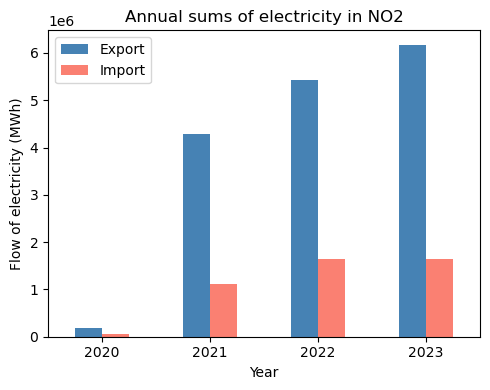

In [69]:
df2['Year'] = df2.index.year                                                                        # Creates a new colum 'year' based on the 'DateTime' index
df2['Indicator'] = df2.apply(lambda x: 'Import' if x['InMapCode'] == 'NO2' else 'Export', axis = 1) # New colum 'Indicator' to tell if its import or export

annual_sum = df2.groupby(['Year','Indicator'])['FlowValue'].sum().unstack(level='Indicator')        # New dataframe with colums: Year, Export, Import

fig3, ax = plt.subplots(figsize=(5,4))                                                              # Creates the plot

annual_sum.plot(kind='bar', color=['steelblue', 'salmon'], ax=ax)                                   # Plots the new annual_sum group.
ax.set_title('Annual sums of electricity in NO2')                                                   # Adding title
ax.tick_params(axis='x', rotation=0)                                                                # Rotates the x-ticks 45 degrees
ax.set_ylabel('Flow of electricity (MWh)')                                                                
ax.set_xlabel('Year')
ax.legend()

plt.tight_layout()                                                                                  # Adjusting the layout

### Task 4

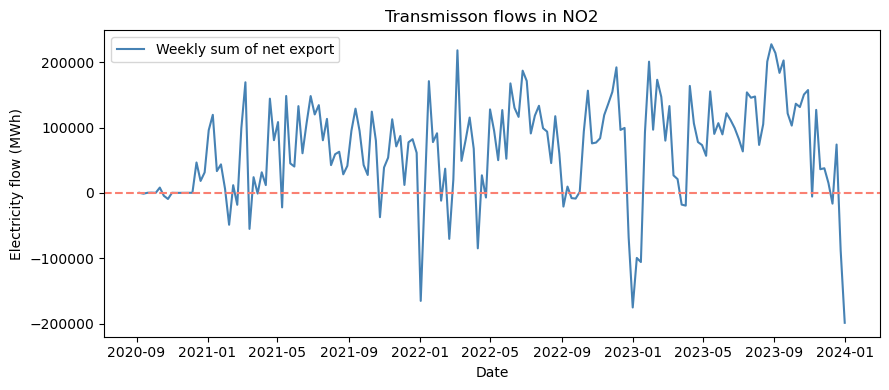

In [70]:
df2['NetExport'] = df2.apply(lambda x: x['FlowValue'] if x['InMapCode'] == 'DE_LU' else -x['FlowValue'], axis=1)

df2_weekly = df2.resample('W')['NetExport'].sum()

fig4, ax = plt.subplots(figsize=(9,4))

ax.plot(df2_weekly, label='Weekly sum of net export', c='steelblue')
ax.axhline(y=0, c='salmon', ls='--', label='')
ax.set_title('Transmisson flows in NO2')
ax.set_ylabel('Electricity flow (MWh)')
ax.set_xlabel('Date')
ax.legend()

plt.tight_layout()

### Task 5

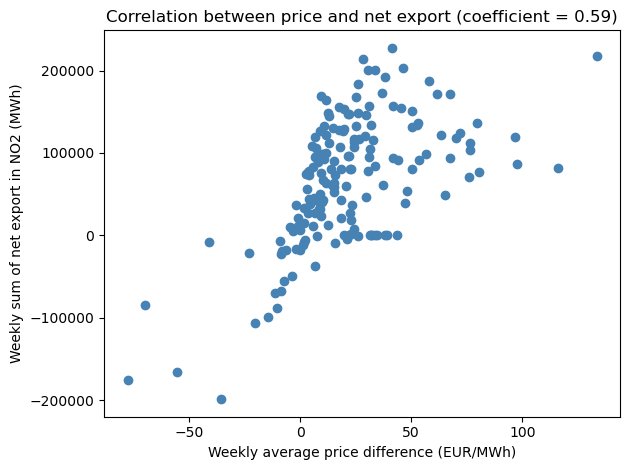

In [71]:
df_hourly = df.loc['2020-09-06':].copy() 
df_hourly['PriceDiff'] = df[df['MapCode'] == 'DE_LU']['Price'] - df[df['MapCode'] == 'NO2']['Price']
df_weekly = df_hourly['PriceDiff'].resample('W').mean()

correlation = df_weekly.corr(df2_weekly)

fig5, ax = plt.subplots()

ax.scatter(df_weekly, df2_weekly, c='steelblue')
ax.set_xlabel('Weekly average price difference (EUR/MWh)')
ax.set_ylabel('Weekly sum of net export in NO2 (MWh)')
ax.set_title(f'Correlation between price and net export (coefficient = {correlation:.2f})', size ='12')

plt.tight_layout()

### Task 6

    https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.tight_layout.html Task 1 and 3. 
    https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.savefig.html Task 1, 3


### Downloading figures

In [72]:
'''
fig1.savefig('figure_task1.png')
table.to_excel('table_task2.xlsx')
fig3.savefig('figure_task3.png') 
fig4.savefig('figure_task4.png')
fig5.savefig('figre_task5.png')
'''

"\nfig1.savefig('figure_task1.png')\ntable.to_excel('table_task2.xlsx')\nfig3.savefig('figure_task3.png') \nfig4.savefig('figure_task4.png')\nfig5.savefig('figre_task5.png')\n"